In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from config import API_KEY
import numpy as np


In [2]:
# Function to fetch data from Nasdaq API
def fetch_stock_data(symbol, api_key):
    url = f"https://data.nasdaq.com/api/v3/datasets/WIKI/{symbol}.json"
    params = {
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['dataset']['data'], columns=data['dataset']['column_names'])

# Fetch data for Exxon Mobile, Chevron, and ConocoPhillips
symbols = {
    'Exxon Mobile': 'XOM',
    'Chevron': 'CVX',
    'ConocoPhillips': 'COP'
}

oil_stock_data = {}
for company, symbol in symbols.items():
    oil_stock_data[company] = fetch_stock_data(symbol, API_KEY)

# Combine the data into a single DataFrame for analysis
combined_oil_data = pd.concat(oil_stock_data.values(), keys=oil_stock_data.keys())
combined_oil_data.reset_index(level=0, inplace=True)
combined_oil_data.rename(columns={'level_0': 'Company'}, inplace=True)

# Save the combined data to a CSV file for further analysis
combined_oil_data.to_csv('outputs/combined_oil_data.csv', index=False)

# Display the combined data to verify
combined_oil_data.head()

,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,Exxon Mobile,2018-03-27,74.00,74.8949,73.2750,73.70,14625541.0,0.0,1.0,74.00,74.8949,73.2750,73.70,14625541.0
1,Exxon Mobile,2018-03-26,73.65,74.1500,72.7548,74.00,14894438.0,0.0,1.0,73.65,74.1500,72.7548,74.00,14894438.0
2,Exxon Mobile,2018-03-23,73.81,74.2100,72.6700,72.89,19069634.0,0.0,1.0,73.81,74.2100,72.6700,72.89,19069634.0
3,Exxon Mobile,2018-03-22,74.42,74.7000,73.3900,73.50,17118037.0,0.0,1.0,74.42,74.7000,73.3900,73.50,17118037.0
4,Exxon Mobile,2018-03-21,74.23,75.6400,73.9800,75.04,14813757.0,0.0,1.0,74.23,75.6400,73.9800,75.04,14813757.0


In [3]:
# Convert the Date column to datetime format
combined_oil_data['Date'] = pd.to_datetime(combined_oil_data['Date'])

# Sort the data by Company and Date
combined_oil_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_oil_data.ffill(inplace=True)
combined_oil_data.bfill(inplace=True)

# Verify the cleaned data
combined_oil_data.head()

,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
12167,Chevron,1970-01-02,51.12,52.25,51.12,52.25,131600.0,0.0,1.0,4.193750,4.286453,4.193750,4.286453,526400.0
12166,Chevron,1970-01-05,52.25,52.88,52.12,52.50,280400.0,0.0,1.0,4.286453,4.338136,4.275788,4.306962,1121600.0
12165,Chevron,1970-01-06,52.50,52.75,51.50,51.75,138400.0,0.0,1.0,4.306962,4.327471,4.224925,4.245434,553600.0
12164,Chevron,1970-01-07,51.75,51.88,51.12,51.62,112800.0,0.0,1.0,4.245434,4.256099,4.193750,4.234769,451200.0
12163,Chevron,1970-01-08,52.25,53.00,52.25,52.62,158800.0,0.0,1.0,4.286453,4.347981,4.286453,4.316806,635200.0


In [4]:
# Filter the data to include only dates from 2017-01-01 to 2017-12-12
start_date = pd.Timestamp('2017-01-01')
end_date = pd.Timestamp('2017-12-12')
filtered_data = combined_oil_data[(combined_oil_data['Date'] >= start_date) & (combined_oil_data['Date'] <= end_date)].copy()

# Extract year and quarter
filtered_data['Year'] = filtered_data['Date'].dt.year
filtered_data['Quarter'] = filtered_data['Date'].dt.to_period('Q')

# Define the colors for each company
colors = {'Exxon Mobile': 'Green', 'Chevron': 'Blue', 'ConocoPhillips': 'Orange'}

/var/folders/rb/2tm7zw5j145975vwqn87sn100000gn/T/ipykernel_75818/2569307473.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_percentage_change = filtered_data.groupby(['Company', 'Quarter'], as_index=False).apply(


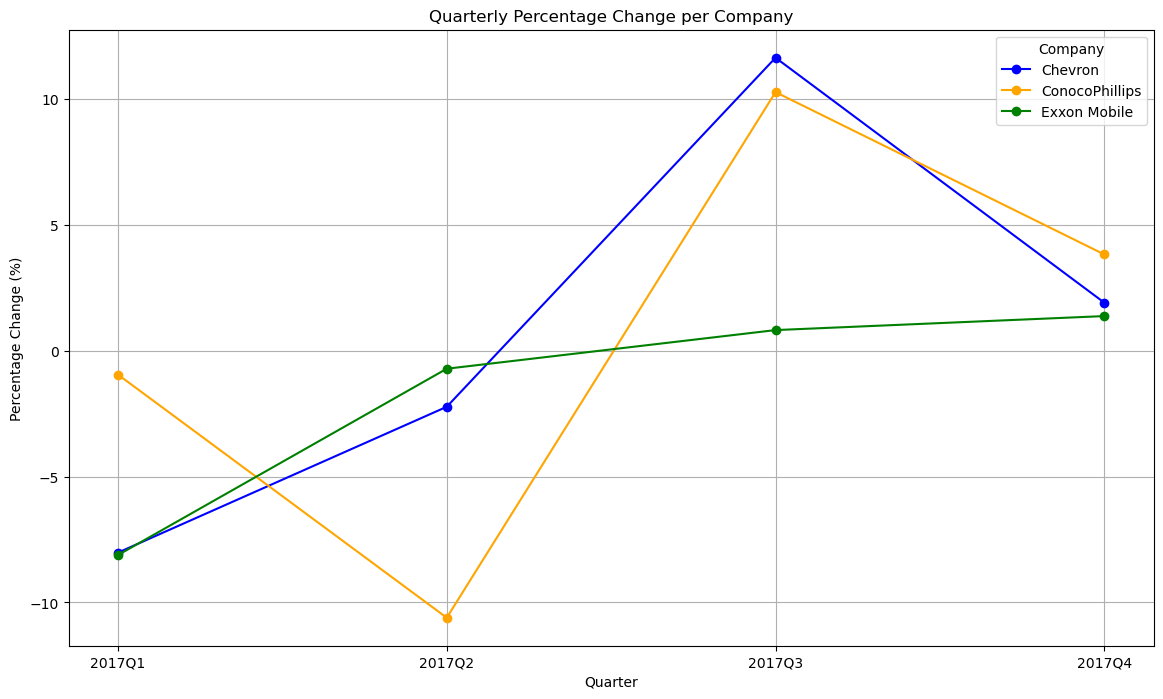

,Company,Quarter,Percentage Change
0,Chevron,2017Q1,-8.018185
1,Chevron,2017Q2,-2.220609
2,Chevron,2017Q3,11.653582
3,Chevron,2017Q4,1.916035
4,ConocoPhillips,2017Q1,-0.941369
5,ConocoPhillips,2017Q2,-10.605330
6,ConocoPhillips,2017Q3,10.286480
7,ConocoPhillips,2017Q4,3.833697
8,Exxon Mobile,2017Q1,-8.114389
9,Exxon Mobile,2017Q2,-0.708045


In [5]:
# Calculate the percentage change for each quarter
quarterly_percentage_change = filtered_data.groupby(['Company', 'Quarter'], as_index=False).apply(
    lambda x: pd.Series({
        'Percentage Change': (x.loc[x['Date'].idxmax()]['Adj. Close'] - x.loc[x['Date'].idxmin()]['Adj. Close']) / x.loc[x['Date'].idxmin()]['Adj. Close'] * 100
    })
)

# Plot the quarterly percentage change
plt.figure(figsize=(14, 8))
for company in quarterly_percentage_change['Company'].unique():
    company_data = quarterly_percentage_change[quarterly_percentage_change['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['Percentage Change'], marker='o', label=company, color=colors[company])

plt.title('Quarterly Percentage Change per Company')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change (%)')
plt.legend(title='Company')
plt.grid(True)
plt.savefig('outputs/quarterly_percentage_change.png')
plt.show()

quarterly_percentage_change

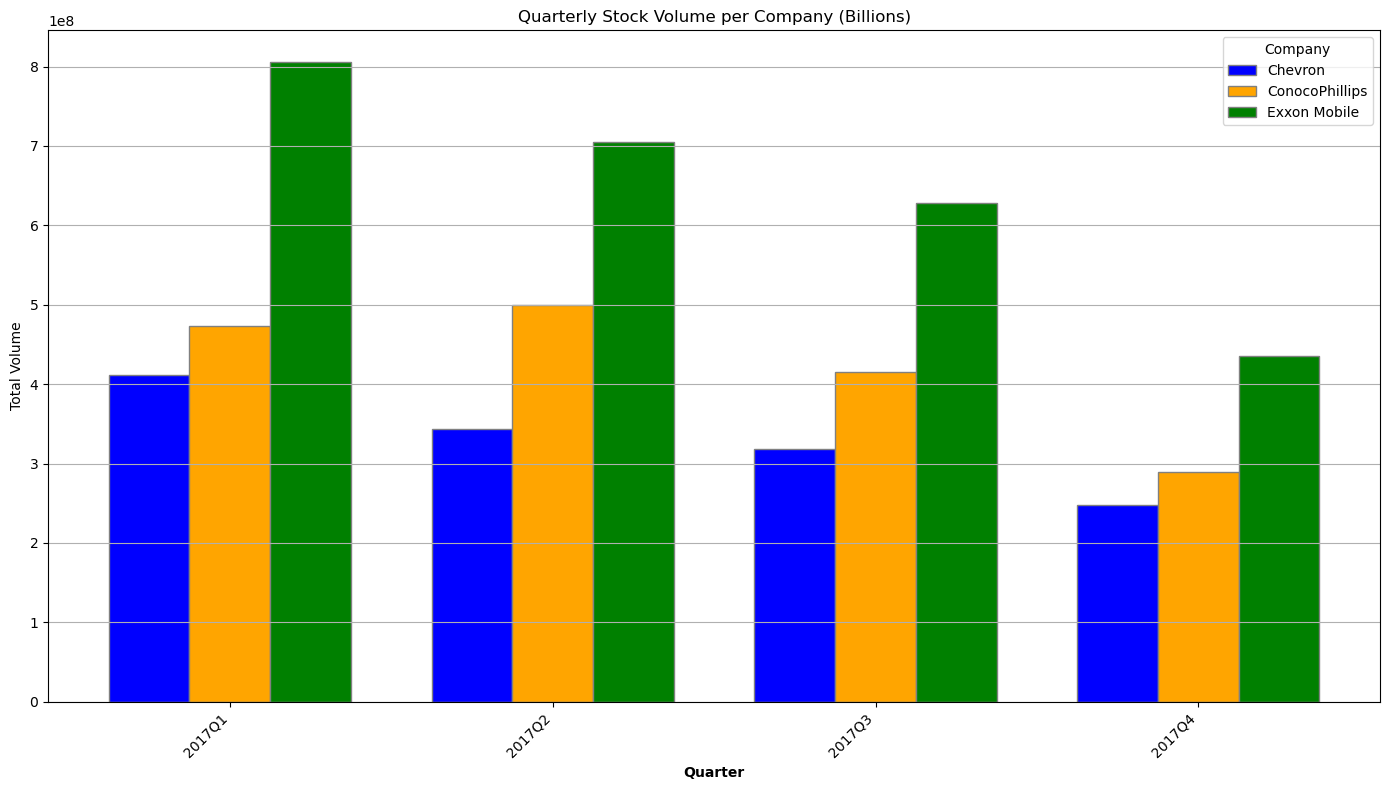

,Company,Quarter,Volume
0,Chevron,2017Q1,411821655.0
1,Chevron,2017Q2,342933559.0
2,Chevron,2017Q3,318949391.0
3,Chevron,2017Q4,247892648.0
4,ConocoPhillips,2017Q1,473859472.0
5,ConocoPhillips,2017Q2,499307686.0
6,ConocoPhillips,2017Q3,415452575.0
7,ConocoPhillips,2017Q4,289125986.0
8,Exxon Mobile,2017Q1,805398170.0
9,Exxon Mobile,2017Q2,705036084.0


In [11]:
# Calculate the quarterly stock volume
quarterly_volume = filtered_data.groupby(['Company', 'Quarter'], as_index=False).agg({
    'Volume': 'sum'
})

# Convert the Quarter to a string for plotting
quarterly_volume['Quarter'] = quarterly_volume['Quarter'].astype(str)

# Get unique quarters and companies
unique_quarters = quarterly_volume['Quarter'].unique()
unique_companies = quarterly_volume['Company'].unique()

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = range(len(unique_quarters))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
plt.figure(figsize=(14, 8))

for i, company in enumerate(unique_companies):
    company_data = quarterly_volume[quarterly_volume['Company'] == company]
    positions = [x + i * bar_width for x in r1]
    plt.bar(positions, company_data['Volume'], width=bar_width, edgecolor='grey', label=company, color=colors[company])

# Add xticks on the middle of the group bars
plt.xlabel('Quarter', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(unique_quarters))], unique_quarters)

plt.title('Quarterly Stock Volume per Company (Billions)')
plt.ylabel('Total Volume')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/quarterly_stock_volume.png')
plt.show()

quarterly_volume

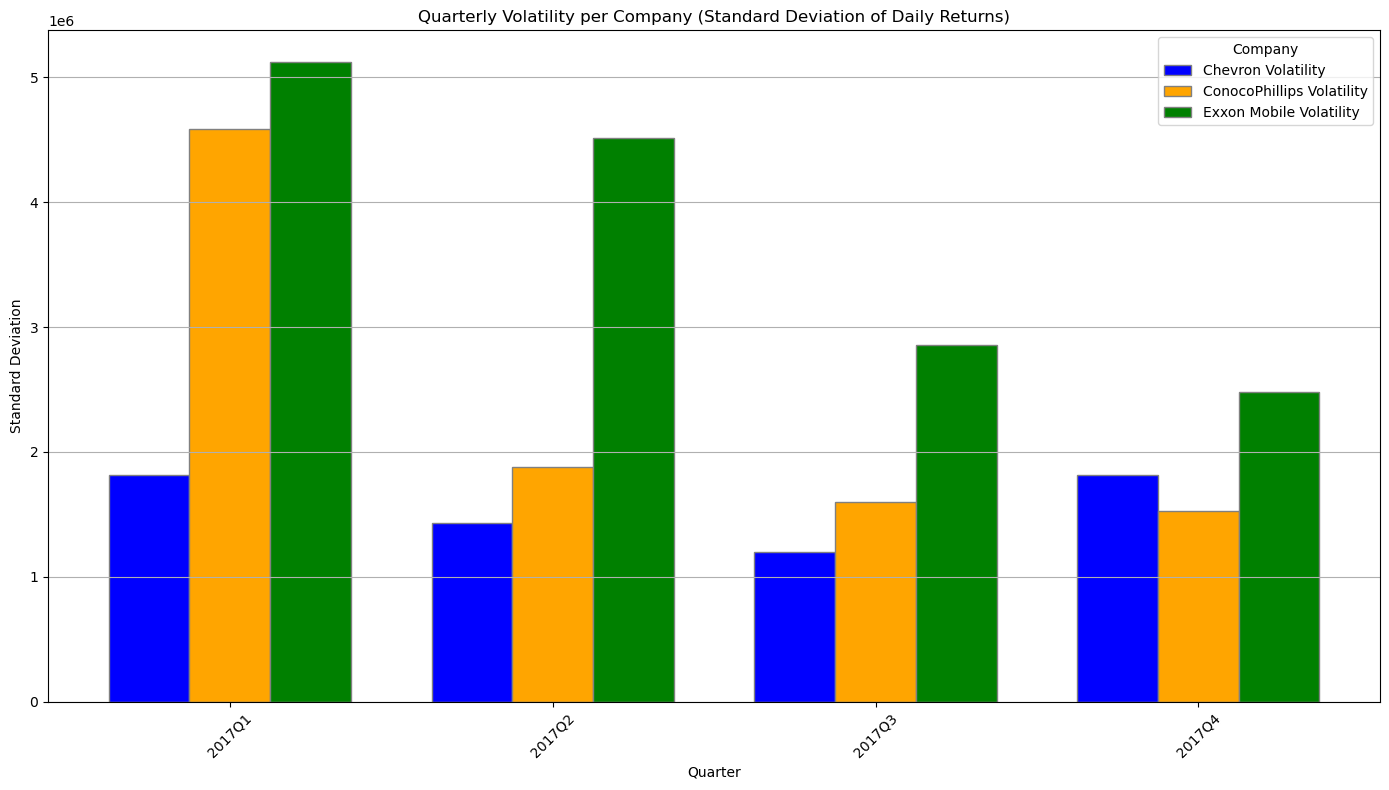

,Company,Quarter,Volume,Volatility
0,Chevron,2017Q1,411821655.0,1.812503e+06
1,Chevron,2017Q2,342933559.0,1.428604e+06
2,Chevron,2017Q3,318949391.0,1.201141e+06
3,Chevron,2017Q4,247892648.0,1.815543e+06
4,ConocoPhillips,2017Q1,473859472.0,4.583744e+06
5,ConocoPhillips,2017Q2,499307686.0,1.876676e+06
6,ConocoPhillips,2017Q3,415452575.0,1.602919e+06
7,ConocoPhillips,2017Q4,289125986.0,1.523276e+06
8,Exxon Mobile,2017Q1,805398170.0,5.118963e+06
9,Exxon Mobile,2017Q2,705036084.0,4.509708e+06


In [10]:
quarterly_volatility = filtered_data.groupby(['Company', 'Quarter'], as_index=False).agg({
    'Volume': ['sum', 'std']
})

# Flatten the MultiIndex columns
quarterly_volatility.columns = ['Company', 'Quarter', 'Volume', 'Volatility']

# Convert the Quarter to a string for plotting
quarterly_volatility['Quarter'] = quarterly_volatility['Quarter'].astype(str)

# Get unique quarters and companies
unique_quarters = quarterly_volatility['Quarter'].unique()
unique_companies = quarterly_volatility['Company'].unique()

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
positions = {company: [x + i * bar_width for x in range(len(unique_quarters))] for i, company in enumerate(unique_companies)}

# Plot the quarterly stock volume bar graph
plt.figure(figsize=(14, 8))

for company in unique_companies:
    company_data = quarterly_volatility[quarterly_volatility['Company'] == company]
    plt.bar(positions[company], company_data['Volatility'], width=bar_width, edgecolor='grey', label=f"{company} Volatility", color=colors[company])

   # Add xticks on the middle of the group bars
plt.xlabel('Quarter')
plt.xticks([r + bar_width for r in range(len(unique_quarters))], unique_quarters)

plt.title('Quarterly Volatility per Company (Standard Deviation of Daily Returns)')
plt.ylabel('Standard Deviation')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/quarterly_stock_volatility.png')
plt.show()

quarterly_volatility

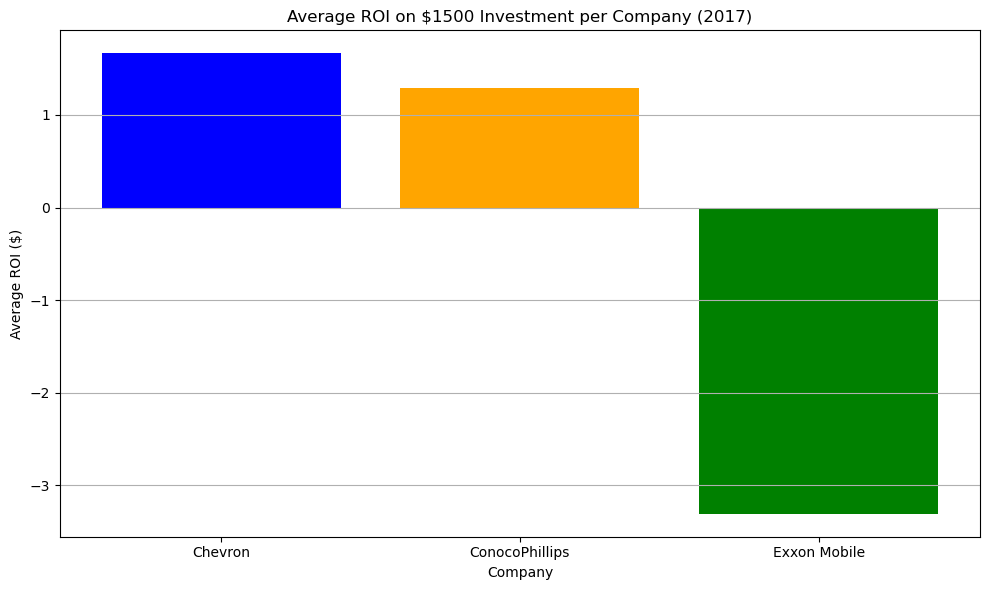

,Company,Expected Return
0,Chevron,1.665411
1,ConocoPhillips,1.286738
2,Exxon Mobile,-3.305337


In [23]:
# Ensure that 'Expected Return' is correctly calculated and remains numeric
quarterly_returns['Expected Return'] = initial_investment * (quarterly_returns['Percentage Change'] / 100)

# Convert the Quarter to a string for consistency
quarterly_returns['Quarter'] = quarterly_returns['Quarter'].astype(str)

# Calculate the average ROI for each company
average_roi = quarterly_returns.groupby('Company').agg({
    'Expected Return': 'mean'
}).reset_index()

# Plot the average ROI
plt.figure(figsize=(10, 6))
plt.bar(average_roi['Company'], average_roi['Expected Return'], color=[colors[company] for company in average_roi['Company']])

plt.title('Average ROI on $1500 Investment per Company (2017)')
plt.ylabel('Average ROI ($)')
plt.xlabel('Company')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('outputs/average_roi.png')
plt.show()

average_roi

In [14]:
from scipy import stats

# Calculate the t-statistic and p-value for each company
results = []

for company in average_roi['Company']:
    roi_data = quarterly_returns[quarterly_returns['Company'] == company]['Expected Return']
    
    # Perform a one-sample t-test against the null hypothesis that the mean ROI = 0
    t_stat, p_value = stats.ttest_1samp(roi_data, 0)
    
    results.append({
        'Company': company,
        't-statistic': t_stat,
        'p-value': p_value
    })

# Convert results to DataFrame
p_value_df = pd.DataFrame(results)

# Display the results
p_value_df

,Company,t-statistic,p-value
0,Chevron,0.201014,0.853544
1,ConocoPhillips,0.146254,0.892996
2,Exxon Mobile,-0.751599,0.506882


/var/folders/rb/2tm7zw5j145975vwqn87sn100000gn/T/ipykernel_75818/2402595062.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_roi = filtered_data.groupby(['Company', 'Quarter']).apply(calculate_quarter_roi).reset_index()


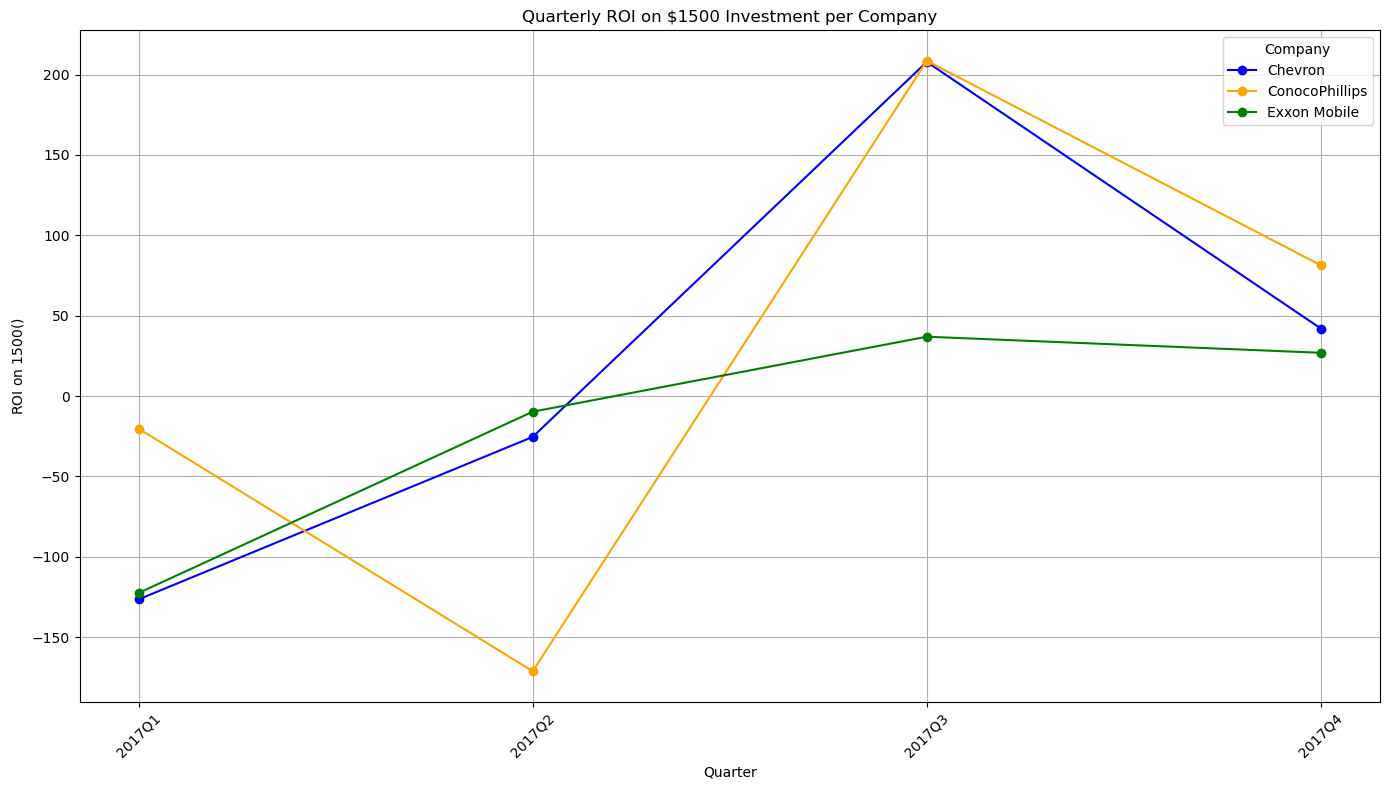

,Company,Quarter,Quarter ROI (%),ROI on $1500 ($)
0,Chevron,2017Q1,-8.429998,-126.449965
1,Chevron,2017Q2,-1.691678,-25.375163
2,Chevron,2017Q3,13.860090,207.901344
3,Chevron,2017Q4,2.800206,42.003092
4,ConocoPhillips,2017Q1,-1.350702,-20.260537
5,ConocoPhillips,2017Q2,-11.411494,-171.172417
6,ConocoPhillips,2017Q3,13.903657,208.554850
7,ConocoPhillips,2017Q4,5.426302,81.394535
8,Exxon Mobile,2017Q1,-8.164909,-122.473629
9,Exxon Mobile,2017Q2,-0.647516,-9.712741


In [17]:
# Calculate the ROI based on quarter opening and closing prices
def calculate_quarter_roi(group):
    opening_price = group.iloc[0]['Adj. Open']  # Assuming 'Adj. Open' is the adjusted opening price
    closing_price = group.iloc[-1]['Adj. Close']  # Assuming 'Adj. Close' is the adjusted closing price
    roi_percentage = ((closing_price - opening_price) / opening_price) * 100
    return pd.Series({
        'Quarter ROI (%)': roi_percentage,
        'ROI on $1500 ($)': (roi_percentage / 100) * 1500
    })

# Apply the ROI calculation to each company for each quarter
quarterly_roi = filtered_data.groupby(['Company', 'Quarter']).apply(calculate_quarter_roi).reset_index()

# Display the results
quarterly_roi

# Now, let's plot the ROI on a $1500 investment
plt.figure(figsize=(14, 8))
for company in quarterly_roi['Company'].unique():
    company_data = quarterly_roi[quarterly_roi['Company'] == company]
    plt.plot(company_data['Quarter'].astype(str), company_data['ROI on $1500 ($)'], marker='o', label=company, color=colors[company])

plt.title('Quarterly ROI on $1500 Investment per Company')
plt.xlabel('Quarter')
plt.ylabel('ROI on $1500 ($)')
plt.legend(title='Company')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/quarterly_roi_on_1500.png')
plt.show()

quarterly_roi

/var/folders/rb/2tm7zw5j145975vwqn87sn100000gn/T/ipykernel_75818/652766784.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  quarterly_roi = filtered_data.groupby(['Company', 'Quarter']).apply(calculate_quarter_roi).reset_index()


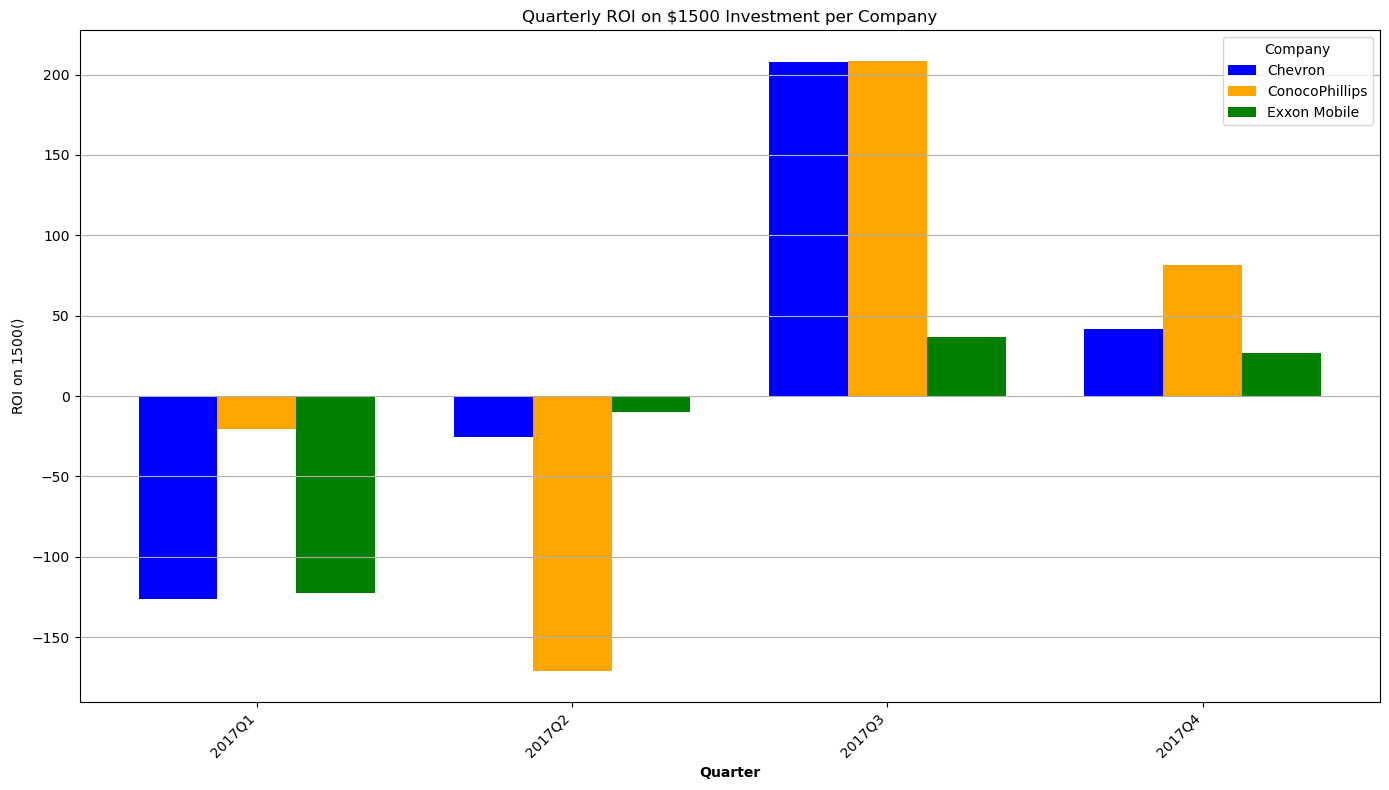

In [16]:
# Calculate the ROI based on quarter opening and closing prices
def calculate_quarter_roi(group):
    opening_price = group.iloc[0]['Adj. Open']  # Assuming 'Adj. Open' is the adjusted opening price
    closing_price = group.iloc[-1]['Adj. Close']  # Assuming 'Adj. Close' is the adjusted closing price
    roi_percentage = ((closing_price - opening_price) / opening_price) * 100
    return pd.Series({
        'Quarter ROI (%)': roi_percentage,
        'ROI on $1500 ($)': (roi_percentage / 100) * 1500
    })

# Apply the ROI calculation to each company for each quarter
quarterly_roi = filtered_data.groupby(['Company', 'Quarter']).apply(calculate_quarter_roi).reset_index()

# Convert Quarter to a string for plotting
quarterly_roi['Quarter'] = quarterly_roi['Quarter'].astype(str)

# Plot the ROI on a $1500 investment using a bar graph
plt.figure(figsize=(14, 8))

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
quarters = quarterly_roi['Quarter'].unique()
positions = np.arange(len(quarters))

# Plot bars for each company
for i, company in enumerate(quarterly_roi['Company'].unique()):
    company_data = quarterly_roi[quarterly_roi['Company'] == company]
    plt.bar(positions + i * bar_width, company_data['ROI on $1500 ($)'], width=bar_width, label=company, color=colors[company])

# Add xticks on the middle of the group bars
plt.xlabel('Quarter', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(quarters))], quarters)

plt.title('Quarterly ROI on $1500 Investment per Company')
plt.ylabel('ROI on $1500 ($)')
plt.legend(title='Company')
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/quarterly_roi_on_1500_bar.png')
plt.show()

In [25]:
# Calculate the percentage change based on the previous code block
# Assuming percentage_change is already calculated as shown before

# Calculate the ROI for a $200 investment
initial_investment = 200
annual_roi['Annual ROI ($)'] = (annual_roi['Percentage Change'] / 100) * initial_investment

# Display the results
annual_roi['Company', 'Jan 1, 2017 Closing Price', 'Dec 31, 2017 Closing Price', 'Percentage Change (%)', 'Annual ROI ($)']

NameError: name 'annual_roi' is not defined